In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [71]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [72]:
from sklearn.preprocessing import LabelEncoder

df=df.drop(['name', 'artists', 'album_name'], axis=1)

# genre_groups = {
#     'j-dance': 0, 'techno': 0, 'mandopop': 0, 'idm': 0, 'chicago-house': 0, 'breakbeat': 0,  # Elettronica/Dance
#     'black-metal': 1,  # Metal/Rock
#     'bluegrass': 2,  # Country/Folk
#     'j-idol': 3, 'spanish': 3, 'disney': 3, 'brazil': 3,  # Pop/Commerciale
#     'iranian': 4, 'afrobeat': 4, 'indian': 4, 'forro': 4,  # World
#     'happy': 5, 'sleep': 5, 'study': 5,  # Ambient/New Age
#     'industrial': 6  # Other
# }
genre_groups = {
    'j-dance': 0, 'techno': 0, 'chicago-house': 0, 'breakbeat': 0, 'idm': 0, 
        'happy': 1, 'sleep': 1, 'study': 1, 'disney': 1, 
        'bluegrass': 2, 'forro': 2, 'mandopop': 2, 'iranian': 2, 'indian': 2, 'brazil': 2, 
        'black-metal': 3, 'industrial': 3, 
        'j-idol': 4, 'spanish': 4, 'afrobeat': 4, 
}

# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

# Stampa del mapping dei generi ai numeri corrispondenti
print(df['genre_group'].unique())

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

drop_attributes=['genre', 'explicit', 'mode', 'time_signature']
df = df.drop(drop_attributes, axis=1)

[4 3 2 0 1]


In [73]:
df.head()

,duration_ms,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_group
0,293106,50,0.401,0.683,8,-5.722,0.0401,0.181,0.000000,0.0837,0.226,135.951,4
1,194972,52,0.672,0.858,3,-5.233,0.1450,0.456,0.811000,0.1040,0.963,166.689,4
2,178428,22,0.636,0.826,3,-7.486,0.0585,0.461,0.271000,0.1410,0.731,102.809,4
3,238373,20,0.733,0.862,7,-5.813,0.0604,0.287,0.000532,0.4660,0.745,107.981,4
4,221893,22,0.712,0.225,5,-10.017,0.0533,0.930,0.001000,0.1230,0.429,87.520,4


In [74]:
from sklearn.model_selection import train_test_split

attributes = [col for col in df.columns if col != 'genre_group']
X = df[attributes].values
y = df['genre_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # we use 70% and 30% and we stratisfy to have the same distribution for the classes between them in the training and in the test set

In [75]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [77]:
# I tuoi iperparametri ottimizzati
best_params_well = {
    'criterion': 'entropy',
    'max_depth': 9,
    'min_samples_leaf': 10,
    'min_samples_split': 30
}

# Istanzia il modello con i migliori iperparametri
dt = DecisionTreeClassifier(**best_params_well, ccp_alpha=0.000428359788359789)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.000428359788359789, criterion='entropy',
                       max_depth=9, min_samples_leaf=10, min_samples_split=30)

In [78]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [79]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.7067619047619048
Train F1-score [0.71604478 0.73010547 0.77878473 0.6691254  0.50933427]

Test Accuracy 0.6575555555555556
Test F1-score [0.67638234 0.66055046 0.7348643  0.59903382 0.47502048]


In [80]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68      1125
           1       0.68      0.64      0.66       900
           2       0.69      0.78      0.73      1350
           3       0.66      0.55      0.60       450
           4       0.53      0.43      0.48       675

    accuracy                           0.66      4500
   macro avg       0.64      0.62      0.63      4500
weighted avg       0.65      0.66      0.65      4500



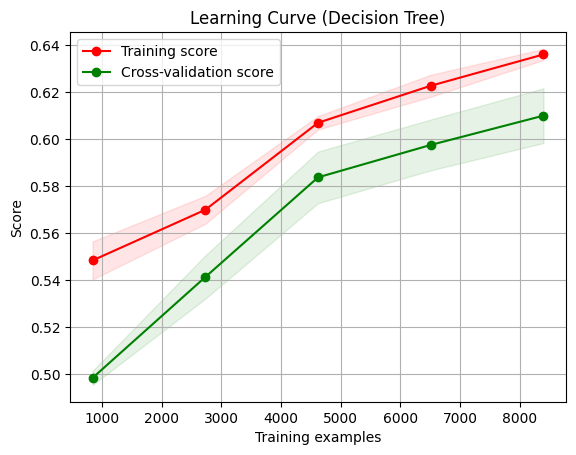

In [108]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Assicurati che il Decision Tree Classifier 'dt' sia già stato definito e addestrato qui

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot della curva di apprendimento per il tuo classificatore
plot_learning_curve(dt, "Learning Curve (Decision Tree)", X_train_norm, y_train, cv=5)

# Mostra il plot
plt.show()


In [81]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [82]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

acousticness 0.22686001513440548
popularity 0.1628466265392331
danceability 0.13709706880725955
duration_ms 0.13323961703975523
instrumentalness 0.11965006559245402
speechiness 0.05209594582722337
valence 0.045547904245937444
energy 0.0453999876110462
loudness 0.04029149266955999
tempo 0.02895681201087054
liveness 0.0052397162074330015
key 0.002774748314822013


#### Decision Tree hyperparameters

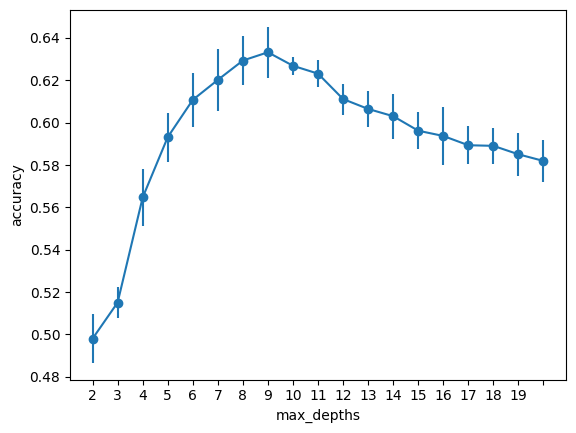

In [83]:
from sklearn.model_selection import cross_val_score

max_depths =  list(np.arange(2, 20)) + [None]
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

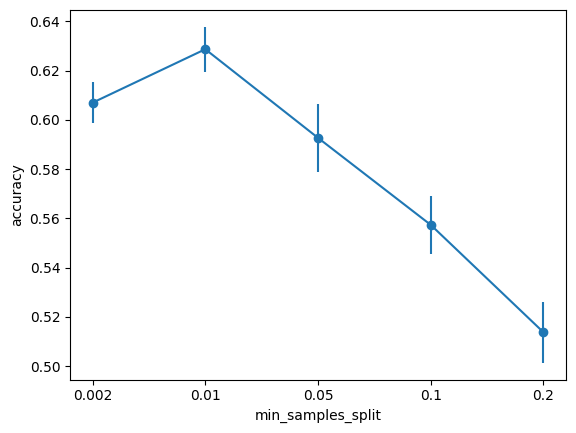

In [84]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split") 
plt.ylabel("accuracy")
plt.show()

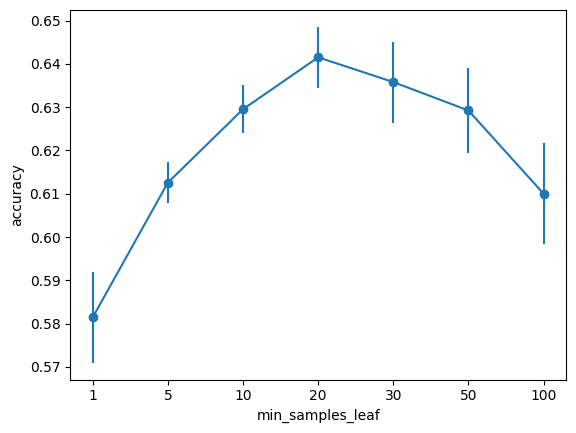

In [85]:
min_samples_leafs = [1, 5, 10, 20, 30, 50, 100]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

### Randomized search

In [86]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [109]:
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

In [110]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 30, 'min_samples_leaf': 20, 'max_depth': 10, 'criterion': 'entropy'} 0.6387238095238095


Test Accuracy: 0.6004444444444444
Test F1 Score: 0.5888539792884816


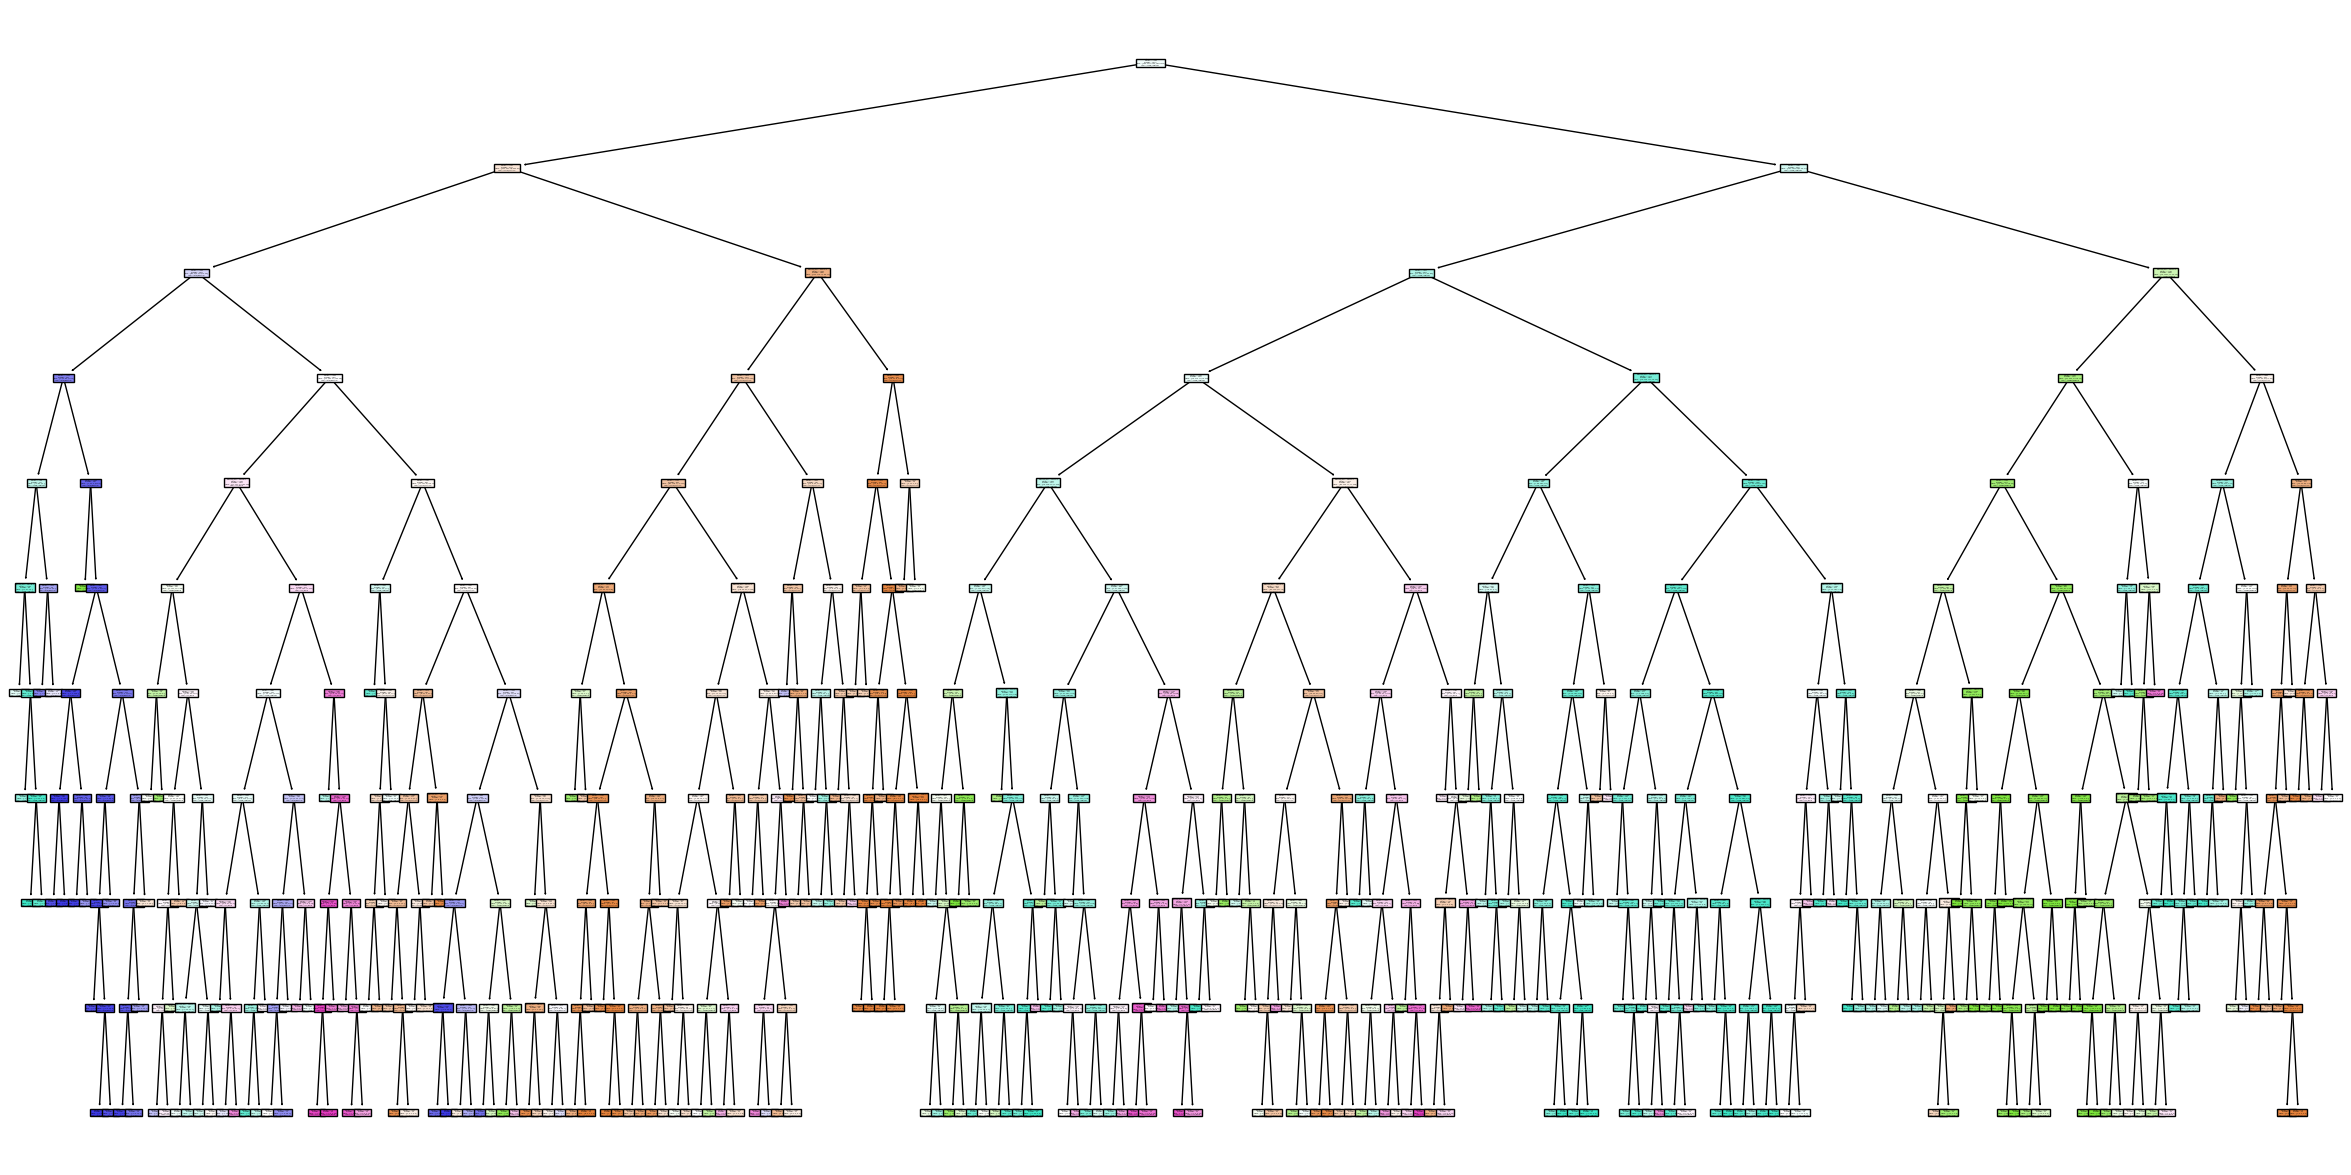

In [111]:
from sklearn.tree import DecisionTreeClassifier

# I tuoi iperparametri ottimizzati
best_params = {
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 20,
    'min_samples_split': 30
}

# Istanzia il modello con i migliori iperparametri
dt_optimized = DecisionTreeClassifier(**best_params)

# Addestra il modello
dt_optimized.fit(X_train, y_train)

# Effettua previsioni sul set di test
y_test_pred_optimized = dt_optimized.predict(X_test)
y_train_pred_optimized = dt_optimized.predict(X_train)

# Valuta il modello
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted') # 'weighted' tiene conto del bilanciamento delle classi

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1_score}')

# Se desideri visualizzare l'albero decisionale
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plot_tree(dt_optimized, feature_names=attributes, class_names=genre_labels, filled=True)
plt.show()


In [112]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dt_optimized.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()


In [113]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred_optimized))
print('Train F1-score %s' % f1_score(y_train, y_train_pred_optimized, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred_optimized))
print('Test F1-score %s' % f1_score(y_test, y_test_pred_optimized, average=None))

Train Accuracy 0.708
Train F1-score [0.71788274 0.72687861 0.77881997 0.66962525 0.51932105]

Test Accuracy 0.6466666666666666
Test F1-score [0.66329541 0.64719359 0.73141231 0.60550459 0.44407346]


In [114]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred_optimized)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [115]:
path = dt_optimized.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [116]:

# Esegui la cross-validation per ogni valore di ccp_alpha e raccogli i punteggi di accuratezza
cv_scores = []
for ccp_alpha in ccp_alphas:
    dt_cv = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Trova il valore di ccp_alpha che massimizza l'accuratezza media della cross-validation
best_ccp_alpha_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_ccp_alpha_index]

# Stampa dei risultati per ccp_alpha
print(f"Best ccp_alpha: {best_ccp_alpha} with cross-validated accuracy: {cv_scores[best_ccp_alpha_index]}")

Best ccp_alpha: 0.0004273469893413006 with cross-validated accuracy: 0.6445714285714287


In [94]:
for alpha, imp in zip(ccp_alphas, impurities):
    print(alpha, imp)

0.0 1.0253385755309647
0.00026764513367333884 1.0256062206646381
0.00028407180803929606 1.0258902924726774
0.0003014713858779919 1.0261917638585554
0.00030670517383796594 1.0264984690323933
0.0003088011639090924 1.0268072701963025
0.0003551468797041062 1.0271624170760065
0.0003615362689288104 1.0275239533449354
0.0003705505075875511 1.027894503852523
0.0003743879845936924 1.0282688918371166
0.0004269815172540315 1.0291228548716247
0.00047297835387764267 1.0295958332255024
0.00048260706565717145 1.0300784402911596
0.0005128659741991753 1.0305913062653587
0.0005425994584302499 1.031133905723789
0.0005547288450488412 1.0316886345688379
0.0005936337214203736 1.0322822682902582
0.0006344240578892188 1.0329166923481474
0.0006430785244054809 1.0335597708725528
0.0006533351250963978 1.0342131059976492
0.0006545682543141248 1.0348676742519634
0.0006584872003696932 1.035526161452333
0.0006634900612525023 1.0361896515135856
0.0006739765085571887 1.0368636280221428
0.0006802804702602305 1.03754390

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

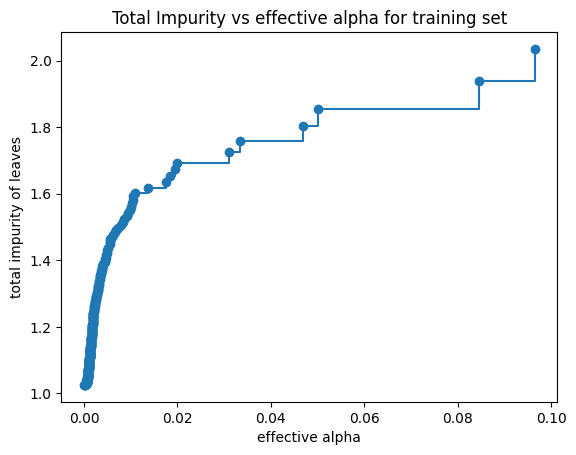

In [95]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [96]:
random_search.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 20,
 'max_depth': 11,
 'criterion': 'entropy'}

In [97]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.19308170520078693


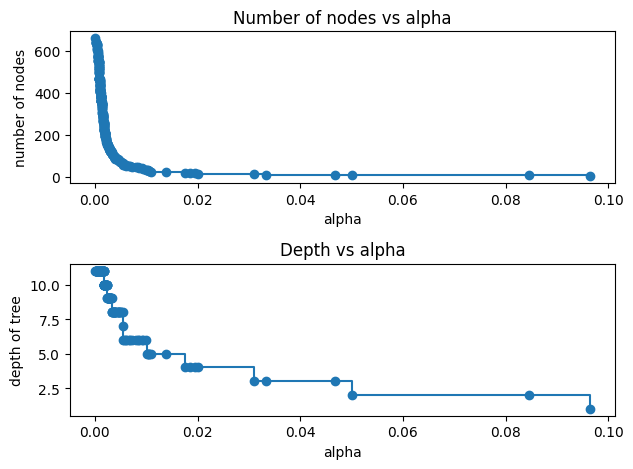

In [98]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

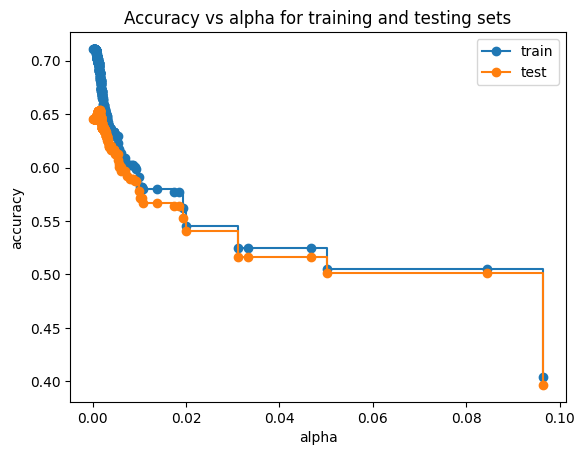

In [99]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [100]:
dtp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.006, **random_search.best_params_)
dtp.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.006, criterion='entropy', max_depth=11,
                       min_samples_leaf=20, min_samples_split=10,
                       random_state=0)

In [101]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.7067619047619048
Train F1-score [0.71604478 0.73010547 0.77878473 0.6691254  0.50933427]

Test Accuracy 0.6575555555555556
Test F1-score [0.67638234 0.66055046 0.7348643  0.59903382 0.47502048]


In [102]:
y_test_pred = dtp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.6004444444444444


In [103]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1125
           1       0.60      0.56      0.58       900
           2       0.63      0.76      0.69      1350
           3       0.76      0.36      0.49       450
           4       0.52      0.33      0.41       675

    accuracy                           0.60      4500
   macro avg       0.61      0.54      0.56      4500
weighted avg       0.60      0.60      0.59      4500



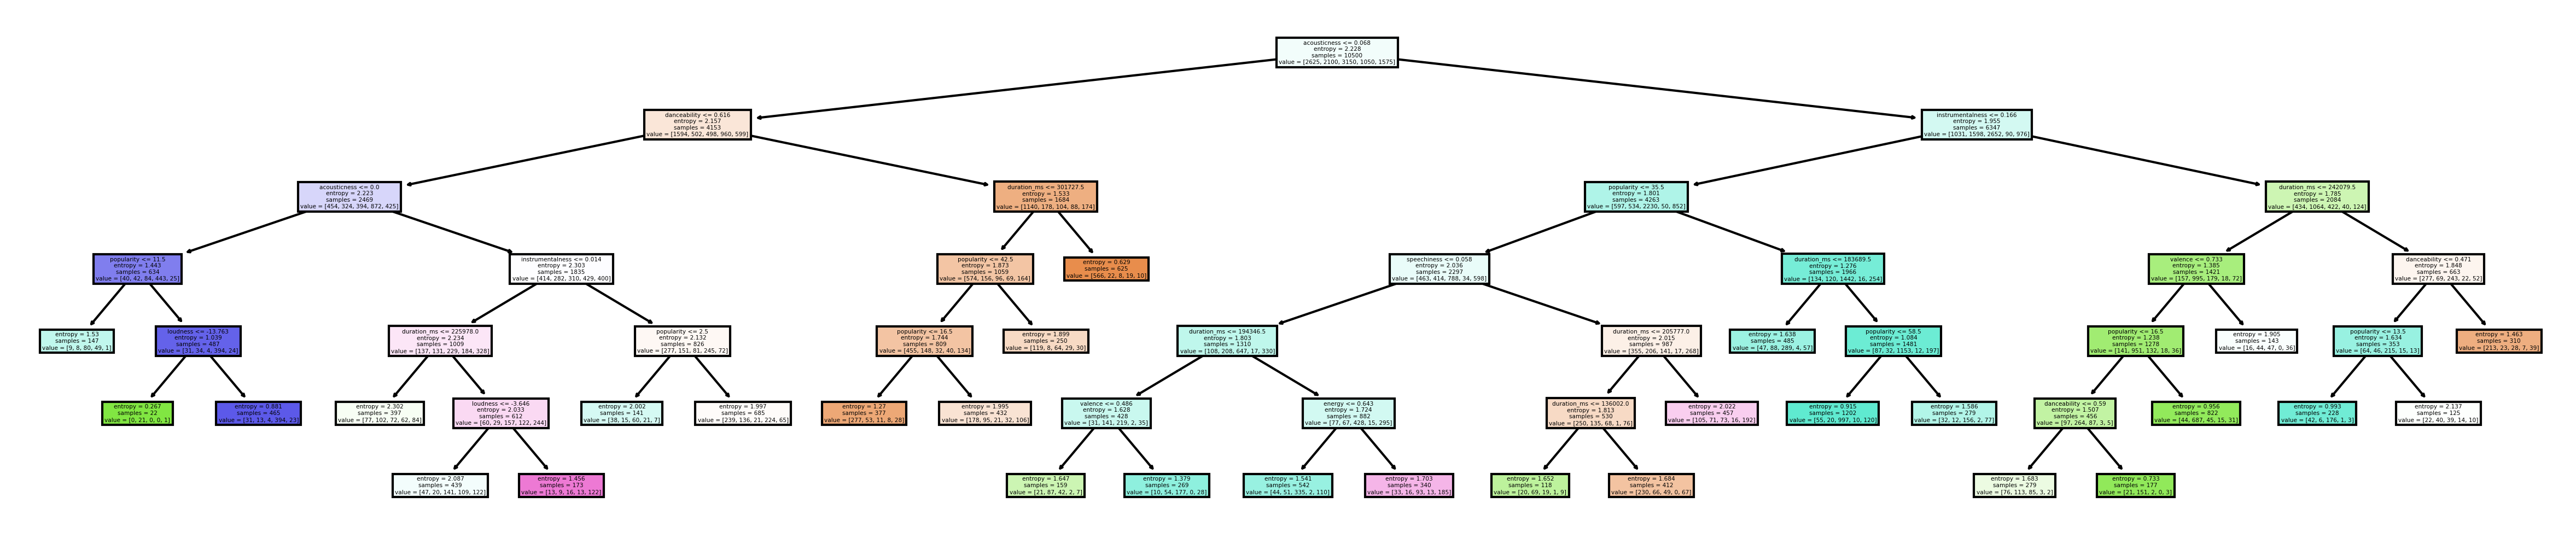

In [104]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dtp, feature_names=attributes, filled=True)
plt.show()

In [105]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dtp.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()
